# 1. Importing Packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


# 2. Loading Data

In [2]:
project_data = pd.read_csv('D:\\train_data.csv')
resource_data = pd.read_csv('D:\\resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('='*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in resources data", resource_data.shape)
print(resource_data.columns.values)

Number of data points in resources data (1541272, 4)
['id' 'description' 'quantity' 'price']


In [5]:
resource_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [6]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [7]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [8]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [9]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [10]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1


In [11]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.NaN,'Mrs.')

# 3. Text Preprocessing

# 3.1. Concatenating all essay text

In [12]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

# 3.2. Preprocessing Essay text

In [13]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[49999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent = decontracted(project_data['essay'].values[16499])
print(sent)
print("="*50) 

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [16]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

I teach an amazing energetic engaged and kind group of 5th grade students in an inner city high poverty public school in Indianapolis Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children My students work hard in class giving 110 with everything that they do They persevere through difficult topics enjoy being engaged in their hands on activities and they love to laugh while learning I set high expectation for my students They understand that true authentic learning takes hard work dedication and requires them to take ownership over their education My goal for my students is to leave my class as life long learners The students work hard to overcome all obstacles in their path to meet and grow past my expectations My students love being active while they are learning and wiggling while they are working I am lucky enough to have one Hokki stools in my classroom Sadly one is not enough to reach all my students My student

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_question1 = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = sent.lower()
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:37<00:00, 1119.77it/s]


In [20]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [21]:
project_data['preprocessed_essays'] = preprocessed_essays 
project_data.drop(['essay'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23,students english learners working english seco...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1,students arrive school eager learn polite gene...


# 3.3. Preprocessing Title text

In [22]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[49999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Young Authors Through Reading


In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
title = decontracted(project_data['project_title'].values[20000])
print(title)
print("="*50)

We Need To Move It While We Input It!


In [25]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
title = title.replace('\\r', ' ')
title = title.replace('\\"', ' ')
title = title.replace('\\n', ' ')
print(title)

We Need To Move It While We Input It!


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
title = re.sub('[^A-Za-z0-9]+', ' ', title)
print(title)

We Need To Move It While We Input It 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [28]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for t in tqdm(project_data['project_title'].values):
    title = decontracted(t)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = title.lower()
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:04<00:00, 24526.04it/s]


In [29]:
# after preprocesing
preprocessed_titles[20000]

'need move input'

In [30]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays,preprocessed_titles
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23,students english learners working english seco...,educational support english learners home
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1,students arrive school eager learn polite gene...,wanted projector hungry learners


In [31]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays,preprocessed_titles
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23,students english learners working english seco...,educational support english learners home
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1,students arrive school eager learn polite gene...,wanted projector hungry learners
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports","\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22,true champions not always ones win guts mia ha...,soccer equipment awesome middle school students
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,232.90,4,work unique school filled esl english second l...,techie kindergarteners
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,67.98,4,second grade classroom next year made around 2...,interactive math tools


# 4. Preprocessing of Categorical data

# 4.1. Preprocessing project_grade_category

In [32]:
project_grade_clean_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-", "_")
    project_grade_clean_category.append(a)

In [33]:
project_grade_clean_category[0:5]

['Grades_PreK_2', 'Grades_6_8', 'Grades_6_8', 'Grades_PreK_2', 'Grades_PreK_2']

In [34]:
project_data['project_grade_clean_category'] = project_grade_clean_category 
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays,preprocessed_titles,project_grade_clean_category
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Literacy & Language,"ESL, Literacy",My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23,students english learners working english seco...,educational support english learners home,Grades_PreK_2
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,"History & Civics, Health & Sports","Civics & Government, Team Sports",Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1,students arrive school eager learn polite gene...,wanted projector hungry learners,Grades_6_8


# 4.2. Preprocessing project_subject_categories


In [35]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [36]:
cat_list[0:5]

['Literacy_Language',
 'History_Civics Health_Sports',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Math_Science']

In [37]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_subject_subcategories,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays,preprocessed_titles,project_grade_clean_category,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,"ESL, Literacy",My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23,students english learners working english seco...,educational support english learners home,Grades_PreK_2,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,"Civics & Government, Team Sports",Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1,students arrive school eager learn polite gene...,wanted projector hungry learners,Grades_6_8,History_Civics Health_Sports


# 4.3. Preprocessing project_subject_subcategories

In [38]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [39]:
sub_cat_list[0:5]

['ESL Literacy',
 'Civics_Government TeamSports',
 'Health_Wellness TeamSports',
 'Literacy Mathematics',
 'Mathematics']

In [40]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays,preprocessed_titles,project_grade_clean_category,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23,students english learners working english seco...,educational support english learners home,Grades_PreK_2,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1,students arrive school eager learn polite gene...,wanted projector hungry learners,Grades_6_8,History_Civics Health_Sports,Civics_Government TeamSports


In [41]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_essays,preprocessed_titles,project_grade_clean_category,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23,students english learners working english seco...,educational support english learners home,Grades_PreK_2,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1,students arrive school eager learn polite gene...,wanted projector hungry learners,Grades_6_8,History_Civics Health_Sports,Civics_Government TeamSports
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22,true champions not always ones win guts mia ha...,soccer equipment awesome middle school students,Grades_6_8,Health_Sports,Health_Wellness TeamSports
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,232.90,4,work unique school filled esl english second l...,techie kindergarteners,Grades_PreK_2,Literacy_Language Math_Science,Literacy Mathematics
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,67.98,4,second grade classroom next year made around 2...,interactive math tools,Grades_PreK_2,Math_Science,Mathematics


# 5. Sentiment score's of each of the essay

In [42]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [43]:
analyser = SentimentIntensityAnalyzer()

In [44]:
neg = []
pos = []
neu = []
compound = []

for a in tqdm(project_data["preprocessed_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [19:44<00:00, 110.56it/s]


In [45]:
project_data["pos"] = pos

In [46]:
project_data["neg"] = neg

In [47]:
project_data["neu"] = neu

In [48]:
project_data["compound"] = compound

In [49]:
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_essay_1,project_essay_2,project_essay_3,project_essay_4,...,quantity,preprocessed_essays,preprocessed_titles,project_grade_clean_category,clean_categories,clean_subcategories,pos,neg,neu,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,...,23,students english learners working english seco...,educational support english learners home,Grades_PreK_2,Literacy_Language,ESL Literacy,0.154,0.013,0.833,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,...,1,students arrive school eager learn polite gene...,wanted projector hungry learners,Grades_6_8,History_Civics Health_Sports,Civics_Government TeamSports,0.305,0.052,0.643,0.9856
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,...,22,true champions not always ones win guts mia ha...,soccer equipment awesome middle school students,Grades_6_8,Health_Sports,Health_Wellness TeamSports,0.230,0.128,0.643,0.9816
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,...,4,work unique school filled esl english second l...,techie kindergarteners,Grades_PreK_2,Literacy_Language Math_Science,Literacy Mathematics,0.256,0.110,0.634,0.9656
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,...,4,second grade classroom next year made around 2...,interactive math tools,Grades_PreK_2,Math_Science,Mathematics,0.151,0.070,0.779,0.8524


# Counting number of words in the combine essays

In [50]:
essay_count = []
for word in project_data['preprocessed_essays']:
    a = len(word.split())
    b = str(a)
    essay_count.append(b)

In [51]:
essay_count[20000]

'112'

In [52]:
project_data['number_of_words_in_essays'] = essay_count 
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_essay_1,project_essay_2,project_essay_3,project_essay_4,...,preprocessed_essays,preprocessed_titles,project_grade_clean_category,clean_categories,clean_subcategories,pos,neg,neu,compound,number_of_words_in_essays
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,...,students english learners working english seco...,educational support english learners home,Grades_PreK_2,Literacy_Language,ESL Literacy,0.154,0.013,0.833,0.9694,149
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,...,students arrive school eager learn polite gene...,wanted projector hungry learners,Grades_6_8,History_Civics Health_Sports,Civics_Government TeamSports,0.305,0.052,0.643,0.9856,99


# Counting number of words in the title

In [53]:
title_count = []
for word in project_data['preprocessed_titles']:
    a = len(word.split())
    b = str(a)
    title_count.append(b)

In [54]:
title_count[20000]

'3'

In [55]:
project_data['number_of_words_in_the_title'] = title_count
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_essay_1,project_essay_2,project_essay_3,project_essay_4,...,preprocessed_titles,project_grade_clean_category,clean_categories,clean_subcategories,pos,neg,neu,compound,number_of_words_in_essays,number_of_words_in_the_title
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,...,educational support english learners home,Grades_PreK_2,Literacy_Language,ESL Literacy,0.154,0.013,0.833,0.9694,149,5
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,...,wanted projector hungry learners,Grades_6_8,History_Civics Health_Sports,Civics_Government TeamSports,0.305,0.052,0.643,0.9856,99,4


# 6. Splitting data into Train and cross validation(or test): Stratified Sampling

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 7. Dropping Target values from Train, Test and CV set

In [57]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(49041, 25)
(36052, 25)
(24155, 25)


In [59]:
X_train.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_essay_1,project_essay_2,project_essay_3,project_essay_4,...,preprocessed_titles,project_grade_clean_category,clean_categories,clean_subcategories,pos,neg,neu,compound,number_of_words_in_essays,number_of_words_in_the_title
41885,83330,p089697,59196edf27a58890f996df4f2f1676b5,Ms.,NY,2017-01-23 18:56:58,"My students are eager, ready to learn, grow an...","I am asking for various flip and solve boards,...",NaN,NaN,...,fantastic 469 ers,Grades_PreK_2,Math_Science SpecialNeeds,Mathematics SpecialNeeds,0.322,0.045,0.633,0.9883,106,3
52855,168474,p055720,f18160078a6f0d758f14d1b015b1a94a,Mrs.,IN,2016-08-16 13:45:44,Exposure to text in a variety of methods is cr...,By incorporating a listening stations into our...,NaN,NaN,...,ear resistable approach building reading skills,Grades_PreK_2,Literacy_Language,Literacy,0.206,0.016,0.778,0.9796,136,6
102669,113143,p167006,b99c47794e28fd5906ca41417ceaad7e,Mrs.,AR,2016-08-25 23:42:22,We all have a special spot we do our best work...,The Wobble Chair is a LIFE-Changer for active ...,NaN,NaN,...,flexible seating allows us focus learning,Grades_3_5,History_Civics Literacy_Language,Economics Literacy,0.254,0.000,0.746,0.9908,147,6
79353,14200,p252903,17fed52e6081078ab376b3af93b9a1d7,Ms.,LA,2016-08-11 21:07:19,My students are inherently creative and lookin...,Each material on our supply list will provide ...,NaN,NaN,...,explorations artmaking developing identities,Grades_9_12,Music_Arts,VisualArts,0.187,0.056,0.757,0.9325,118,4
9123,86543,p056139,1b3647fe92d956652cff2459ae4c4c9a,Mr.,WI,2016-08-24 20:12:29,I teach 18 first grade age students who love s...,During the school day I noticed that my studen...,NaN,NaN,...,time move,Grades_PreK_2,Health_Sports,Health_Wellness,0.294,0.057,0.649,0.9921,148,2


In [60]:
y_train.head()

41885     1
52855     1
102669    1
79353     1
9123      1
Name: project_is_approved, dtype: int64

# 8. Encoding Categorical Data

# 8.1. One Hot Encoding of clean_categories

In [61]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['clean_categories'].values:
#     my_counter.update(word.split())

# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# cat_dict = dict(my_counter)
# sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [62]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot_Xtrain = vectorizer.transform(X_train['clean_categories'].values)
categories_one_hot_Xtest = vectorizer.transform(X_test['clean_categories'].values)
categories_one_hot_Xcv = vectorizer.transform(X_cv['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xtest.shape)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xcv.shape)

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of matrix after one hot encodig  (49041, 9)
Shape of matrix after one hot encodig  (36052, 9)
Shape of matrix after one hot encodig  (24155, 9)


# 8.2. One Hot Encoding of clean_subcategories

In [63]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['clean_subcategories'].values:
#     my_counter.update(word.split())

# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# sub_cat_dict = dict(my_counter)
# sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [64]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot_Xtrain = vectorizer.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_Xtest = vectorizer.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_Xcv = vectorizer.transform(X_cv['clean_subcategories'].values)

print("Shape of matrix after one hot encoding ",sub_categories_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_Xtest.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_Xcv.shape)

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of matrix after one hot encoding  (49041, 30)
Shape of matrix after one hot encodig  (36052, 30)
Shape of matrix after one hot encodig  (24155, 30)


# 8.3. One Hot Encoding of school_state

In [65]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['school_state'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# school_state_dict = dict(my_counter)
# sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

In [66]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot_Xtrain = vectorizer.transform(X_train['school_state'].values)
school_state_one_hot_Xtest = vectorizer.transform(X_test['school_state'].values)
school_state_one_hot_Xcv = vectorizer.transform(X_cv['school_state'].values)

print("Shape of matrix after one hot encoding ",school_state_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",school_state_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",school_state_one_hot_Xcv.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encoding  (49041, 51)
Shape of matrix after one hot encoding  (36052, 51)
Shape of matrix after one hot encoding  (24155, 51)


# 8.4. One Hot Encoding of teacher_prefix

In [67]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['teacher_prefix'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# teacher_prefix_dict = dict(my_counter)
# sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

In [68]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefix_one_hot_Xtrain = vectorizer.transform(X_train['teacher_prefix'].values)
teacher_prefix_one_hot_Xtest = vectorizer.transform(X_test['teacher_prefix'].values)
teacher_prefix_one_hot_Xcv = vectorizer.transform(X_cv['teacher_prefix'].values)

print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xcv.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encoding  (49041, 5)
Shape of matrix after one hot encoding  (36052, 5)
Shape of matrix after one hot encoding  (24155, 5)


# 8.5. One Hot Encoding of project_grade_clean_category

In [69]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['project_grade_clean_category'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# grade_dict = dict(my_counter)
# sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))

In [70]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_clean_category'].values)
print(vectorizer.get_feature_names())


grade_one_hot_Xtrain = vectorizer.transform(X_train['project_grade_clean_category'].values)
grade_one_hot_Xtest = vectorizer.transform(X_test['project_grade_clean_category'].values)
grade_one_hot_Xcv = vectorizer.transform(X_cv['project_grade_clean_category'].values)

print("Shape of matrix after one hot encoding ",grade_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_Xcv.shape)

['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
Shape of matrix after one hot encoding  (49041, 4)
Shape of matrix after one hot encoding  (36052, 4)
Shape of matrix after one hot encoding  (24155, 4)


# 9. Encoding of Text Data

# 9.1.1. BOW with bi-grams with (min_df=10 and max_features=5000) Encoding on preprocessed_essays

In [71]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(ngram_range = (2,2) , min_df=10 , max_features = 5000)
text_bow_Xtrain = vectorizer.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtrain.shape)
text_bow_Xtest = vectorizer.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtest.shape)
text_bow_Xcv = vectorizer.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 5000)
Shape of matrix after one hot encodig  (36052, 5000)
Shape of matrix after one hot encodig  (24155, 5000)


# 9.1.2. BOW Encoding on preprocessed_titles

In [72]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
title_bow_Xtrain = vectorizer.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtrain.shape)
title_bow_Xtest = vectorizer.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtest.shape)
title_bow_Xcv = vectorizer.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 2022)
Shape of matrix after one hot encodig  (36052, 2022)
Shape of matrix after one hot encodig  (24155, 2022)


# 9.2.1. TFIDF with bi-grams with (min_df=10 and max_features=5000) Encoding on preprocessed_essays

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2,2) , min_df=10 , max_features = 5000)
text_tfidf_Xtrain = vectorizer.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtrain.shape)
text_tfidf_Xtest = vectorizer.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtest.shape)
text_tfidf_Xcv = vectorizer.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 5000)
Shape of matrix after one hot encodig  (36052, 5000)
Shape of matrix after one hot encodig  (24155, 5000)


# 9.2.2. TFIDF Encoding on preprocessed_titles

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf_Xtrain = vectorizer.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtrain.shape)
title_tfidf_Xtest = vectorizer.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtest.shape)
title_tfidf_Xcv = vectorizer.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 2022)
Shape of matrix after one hot encodig  (36052, 2022)
Shape of matrix after one hot encodig  (24155, 2022)


# 9.3.1. Average Word2Vec encoding of preprocessed_essays on Train Data

In [75]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('D:\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [76]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtrain.append(vector)

print(len(avg_w2v_vectors_essays_Xtrain))
print(len(avg_w2v_vectors_essays_Xtrain[2]))

100%|██████████████████████████████████████████████████████████████████████████| 49041/49041 [00:22<00:00, 2181.49it/s]


49041
300


In [77]:
average_w2v_on_essay_Xtrain = np.vstack(avg_w2v_vectors_essays_Xtrain)
print(average_w2v_on_essay_Xtrain.shape)

(49041, 300)


# 9.3.2. Average Word2Vec encoding of preprocessed_essays on Test Data

In [78]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtest.append(vector)

print(len(avg_w2v_vectors_essays_Xtest))
print(len(avg_w2v_vectors_essays_Xtest[2]))

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:16<00:00, 2170.56it/s]


36052
300


In [79]:
average_w2v_on_essay_Xtest = np.vstack(avg_w2v_vectors_essays_Xtest)
print(average_w2v_on_essay_Xtest.shape)

(36052, 300)


# 9.3.3. Average Word2Vec encoding of preprocessed_essays on CV Data

In [80]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xcv.append(vector)

print(len(avg_w2v_vectors_essays_Xcv))
print(len(avg_w2v_vectors_essays_Xcv[2]))

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:11<00:00, 2019.04it/s]


24155
300


In [81]:
average_w2v_on_essay_Xcv = np.vstack(avg_w2v_vectors_essays_Xcv)
print(average_w2v_on_essay_Xcv.shape)

(24155, 300)


# 9.4.1. Average Word2Vec encoding of preprocessed_titles on Train Data

In [82]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtrain.append(vector)

print(len(avg_w2v_vectors_titles_Xtrain))
print(len(avg_w2v_vectors_titles_Xtrain[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:01<00:00, 38636.98it/s]


49041
300


In [83]:
average_w2v_on_titles_Xtrain = np.vstack(avg_w2v_vectors_titles_Xtrain)
print(average_w2v_on_titles_Xtrain.shape)

(49041, 300)


# 9.4.2. Average Word2Vec encoding of preprocessed_titles on Test Data

In [84]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtest.append(vector)

print(len(avg_w2v_vectors_titles_Xtest))
print(len(avg_w2v_vectors_titles_Xtest[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 32733.74it/s]


36052
300


In [85]:
average_w2v_on_titles_Xtest = np.vstack(avg_w2v_vectors_titles_Xtest)
print(average_w2v_on_titles_Xtest.shape)

(36052, 300)


# 9.4.3. Average Word2Vec encoding of preprocessed_titles on CV Data

In [86]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xcv.append(vector)

print(len(avg_w2v_vectors_titles_Xcv))
print(len(avg_w2v_vectors_titles_Xcv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 34526.86it/s]


24155
300


In [87]:
average_w2v_on_titles_Xcv = np.vstack(avg_w2v_vectors_titles_Xcv)
print(average_w2v_on_titles_Xcv.shape)

(24155, 300)


# 9.5.1. TFIDF weighted Word2Vec encoding of preprocessed_essays on Train Data

In [88]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [90]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49041/49041 [02:38<00:00, 309.89it/s]


49041
300


In [91]:
tfidf_weighted_w2v_on_essay_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtrain)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)

(49041, 300)


# 9.5.2. TFIDF weighted Word2Vec encoding of preprocessed_essays on Test Data

In [92]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [93]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtest))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtest[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:54<00:00, 313.92it/s]


36052
300


In [94]:
tfidf_weighted_w2v_on_essay_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtest)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)

(36052, 300)


# 9.5.3. TFIDF weighted Word2Vec encoding of preprocessed_essays on CV Data

In [95]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [96]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xcv))
print(len(tfidf_weighted_w2v_vectors_eassays_Xcv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [01:11<00:00, 338.10it/s]


24155
300


In [97]:
tfidf_weighted_w2v_on_essay_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xcv)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)

(24155, 300)


# 9.6.1. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Train Data

In [100]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [101]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtrain))
print(len(tfidf_weighted_w2v_vectors_title_Xtrain[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:02<00:00, 18702.95it/s]


49041
300


In [102]:
tfidf_weighted_w2v_on_title_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_title_Xtrain)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)

(49041, 300)


# 9.6.2. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Test Data

In [103]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [104]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtest))
print(len(tfidf_weighted_w2v_vectors_title_Xtest[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 18983.67it/s]


36052
300


In [105]:
tfidf_weighted_w2v_on_title_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_title_Xtest)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)

(36052, 300)


# 9.6.3. TFIDF Weighted Word2Vec encoding of preprocessed_titles on CV Data

In [106]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [107]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xcv))
print(len(tfidf_weighted_w2v_vectors_title_Xcv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:01<00:00, 19603.52it/s]


24155
300


In [108]:
tfidf_weighted_w2v_on_title_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_title_Xcv)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)

(24155, 300)


# 10. Encoding of Numerical Data

# 10.1. Encoding of price on Train,Test and CV data

In [109]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler


scalar = MinMaxScaler()
 
price_standardized_Xtrain = scalar.fit_transform(X_train['price'].values.reshape(-1, 1))
price_standardized_Xtest = scalar.transform(X_test['price'].values.reshape(-1,1))
price_standardized_Xcv = scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [110]:
price_standardized_Xtrain

array([[0.03870735],
       [0.03481662],
       [0.0079065 ],
       ...,
       [0.01636711],
       [0.04439443],
       [0.01786139]])

In [111]:
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.2. Encoding of quantity on Train,Test and CV data

In [112]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

quantity_standardized_Xtrain = scalar.fit_transform(X_train['quantity'].values.reshape(-1, 1))
quantity_standardized_Xtest = scalar.transform(X_test['quantity'].values.reshape(-1, 1))
quantity_standardized_Xcv = scalar.transform(X_cv['quantity'].values.reshape(-1, 1))

In [113]:
quantity_standardized_Xtrain

array([[0.01001112],
       [0.00111235],
       [0.00333704],
       ...,
       [0.00556174],
       [0.        ],
       [0.00222469]])

In [114]:
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.3. Encoding of teacher_number_of_previously_posted_projects on Train,Test and CV data

In [115]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

# Now standardize the data with above maen and variance.
teacher_number_of_previously_posted_projects_standardized_Xtrain = scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_number_of_previously_posted_projects_standardized_Xtest = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 
teacher_number_of_previously_posted_projects_standardized_Xcv = scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 

In [116]:
teacher_number_of_previously_posted_projects_standardized_Xtrain

array([[0.00665188],
       [0.00221729],
       [0.03104213],
       ...,
       [0.00443459],
       [0.00443459],
       [0.0886918 ]])

In [117]:
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.4.1. Encoding of pos on Train,Test and CV data

In [118]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_pos_standardized_Xtrain = scalar.fit_transform(X_train['pos'].values.reshape(-1, 1))
essay_pos_standardized_Xtest = scalar.transform(X_test['pos'].values.reshape(-1, 1))
essay_pos_standardized_Xcv = scalar.transform(X_cv['pos'].values.reshape(-1, 1))

In [119]:
essay_pos_standardized_Xtrain

array([[0.52786885],
       [0.33770492],
       [0.41639344],
       ...,
       [0.15901639],
       [0.26557377],
       [0.49344262]])

In [120]:
print(essay_pos_standardized_Xtrain.shape)
print(essay_pos_standardized_Xtest.shape)
print(essay_pos_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.5.1. Encoding of neg on Train,Test and CV data

In [121]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_neg_standardized_Xtrain = scalar.fit_transform(X_train['neg'].values.reshape(-1, 1))
essay_neg_standardized_Xtest = scalar.transform(X_test['neg'].values.reshape(-1, 1))
essay_neg_standardized_Xcv = scalar.transform(X_cv['neg'].values.reshape(-1, 1))

In [122]:
essay_neg_standardized_Xtrain

array([[0.13888889],
       [0.04938272],
       [0.        ],
       ...,
       [0.59567901],
       [0.15432099],
       [0.24382716]])

In [123]:
print(essay_neg_standardized_Xtrain.shape)
print(essay_neg_standardized_Xtest.shape)
print(essay_neg_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.6.1. Encoding of neu on Train,Test and CV  data

In [124]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_neu_standardized_Xtrain = scalar.fit_transform(X_train['neu'].values.reshape(-1, 1))
essay_neu_standardized_Xtest = scalar.transform(X_test['neu'].values.reshape(-1, 1))
essay_neu_standardized_Xcv = scalar.transform(X_cv['neu'].values.reshape(-1, 1))

In [125]:
essay_neu_standardized_Xtrain 

array([[0.42204724],
       [0.6503937 ],
       [0.6       ],
       ...,
       [0.54173228],
       [0.66771654],
       [0.4015748 ]])

In [126]:
print(essay_neu_standardized_Xtrain.shape)
print(essay_neu_standardized_Xtest.shape)
print(essay_neu_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.7.1. Encoding of compound on Train,Test and CV data

In [127]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_compound_standardized_Xtrain = scalar.fit_transform(X_train['compound'].values.reshape(-1, 1))
essay_compound_standardized_Xtest = scalar.transform(X_test['compound'].values.reshape(-1, 1))
essay_compound_standardized_Xcv = scalar.transform(X_cv['compound'].values.reshape(-1, 1))

In [128]:
essay_compound_standardized_Xtrain

array([[0.9943823 ],
       [0.99001856],
       [0.99563625],
       ...,
       [0.01394392],
       [0.97968601],
       [0.98906556]])

In [129]:
print(essay_compound_standardized_Xtrain.shape)
print(essay_compound_standardized_Xtest.shape)
print(essay_compound_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.8.1. Encoding of number_of_words_in_essays on Train,Test and CV data

In [130]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

number_of_words_in_essays_standardized_Xtrain = scalar.fit_transform(X_train['number_of_words_in_essays'].values.reshape(-1, 1))
number_of_words_in_essays_standardized_Xtest = scalar.transform(X_test['number_of_words_in_essays'].values.reshape(-1, 1))
number_of_words_in_essays_standardized_Xcv = scalar.transform(X_cv['number_of_words_in_essays'].values.reshape(-1, 1))

In [131]:
number_of_words_in_essays_standardized_Xtrain

array([[0.14741036],
       [0.26693227],
       [0.31075697],
       ...,
       [0.37848606],
       [0.44621514],
       [0.12749004]])

In [132]:
print(number_of_words_in_essays_standardized_Xtrain.shape)
print(number_of_words_in_essays_standardized_Xtest.shape)
print(number_of_words_in_essays_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10.9.1. Encoding of number_of_words_in_the_title on Train,Test and CV data

In [133]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

number_of_words_in_the_title_standardized_Xtrain = scalar.fit_transform(X_train['number_of_words_in_the_title'].values.reshape(-1, 1))
number_of_words_in_the_title_standardized_Xtest = scalar.transform(X_test['number_of_words_in_the_title'].values.reshape(-1, 1))
number_of_words_in_the_title_standardized_Xcv = scalar.transform(X_cv['number_of_words_in_the_title'].values.reshape(-1, 1))

In [134]:
number_of_words_in_the_title_standardized_Xtrain

array([[0.2       ],
       [0.4       ],
       [0.4       ],
       ...,
       [0.2       ],
       [0.26666667],
       [0.26666667]])

In [135]:
print(number_of_words_in_the_title_standardized_Xtrain.shape)
print(number_of_words_in_the_title_standardized_Xtest.shape)
print(number_of_words_in_the_title_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 11. Printing Dimensions of all Preprocessed Data

In [136]:
print(categories_one_hot_Xtrain.shape)
print(categories_one_hot_Xtest.shape)
print(categories_one_hot_Xcv.shape)
print(sub_categories_one_hot_Xtrain.shape)
print(sub_categories_one_hot_Xtest.shape)
print(sub_categories_one_hot_Xcv.shape)
print(school_state_one_hot_Xtrain.shape)
print(school_state_one_hot_Xtest.shape)
print(school_state_one_hot_Xcv.shape)
print(teacher_prefix_one_hot_Xtrain.shape)
print(teacher_prefix_one_hot_Xtest.shape)
print(teacher_prefix_one_hot_Xcv.shape)
print(grade_one_hot_Xtrain.shape)
print(grade_one_hot_Xtest.shape)
print(grade_one_hot_Xcv.shape)
print(text_bow_Xtrain.shape)
print(text_bow_Xtest.shape)
print(text_bow_Xcv.shape)
print(title_bow_Xtrain.shape)
print(title_bow_Xtest.shape)
print(title_bow_Xcv.shape)
print(text_tfidf_Xtrain.shape)
print(text_tfidf_Xtest.shape)
print(text_tfidf_Xcv.shape)
print(title_tfidf_Xtrain.shape)
print(title_tfidf_Xtest.shape)
print(title_tfidf_Xcv.shape)
print(average_w2v_on_essay_Xtrain.shape)
print(average_w2v_on_essay_Xtest.shape)
print(average_w2v_on_essay_Xcv.shape)
print(average_w2v_on_titles_Xtrain.shape)
print(average_w2v_on_titles_Xtest.shape)
print(average_w2v_on_titles_Xcv.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv .shape)
print(essay_pos_standardized_Xtrain.shape)
print(essay_pos_standardized_Xtest.shape)
print(essay_pos_standardized_Xcv.shape)
print(essay_neg_standardized_Xtrain.shape)
print(essay_neg_standardized_Xtest.shape)
print(essay_neg_standardized_Xcv.shape)
print(essay_neu_standardized_Xtrain.shape)
print(essay_neu_standardized_Xtest.shape)
print(essay_neu_standardized_Xcv.shape)
print(essay_compound_standardized_Xtrain.shape)
print(essay_compound_standardized_Xtest.shape)
print(essay_compound_standardized_Xcv.shape)
print(number_of_words_in_essays_standardized_Xtrain.shape)
print(number_of_words_in_essays_standardized_Xtest.shape)
print(number_of_words_in_essays_standardized_Xcv.shape)
print(number_of_words_in_the_title_standardized_Xtrain.shape)
print(number_of_words_in_the_title_standardized_Xtest.shape)
print(number_of_words_in_the_title_standardized_Xcv.shape)

(49041, 9)
(36052, 9)
(24155, 9)
(49041, 30)
(36052, 30)
(24155, 30)
(49041, 51)
(36052, 51)
(24155, 51)
(49041, 5)
(36052, 5)
(24155, 5)
(49041, 4)
(36052, 4)
(24155, 4)
(49041, 5000)
(36052, 5000)
(24155, 5000)
(49041, 2022)
(36052, 2022)
(24155, 2022)
(49041, 5000)
(36052, 5000)
(24155, 5000)
(49041, 2022)
(36052, 2022)
(24155, 2022)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)


# 12.  Creating Different Sets of Data for Training Model

# Set 1: categorical, numerical features + project_title(BOW)   +preprocessed_eassay (BOW with bi-grams with min_df=10 and max_features=5000)

In [137]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain1 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_bow_Xtrain,title_bow_Xtrain)).tocsr()
Xtest1 = hstack(( categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest,grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_bow_Xtest,title_bow_Xtest)).tocsr()
Xcv1 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_bow_Xcv,title_bow_Xcv)).tocsr()

print(Xtrain1.shape,y_train.shape)
print(Xtest1.shape,y_test.shape)
print(Xcv1.shape,y_cv.shape)

(49041, 7124) (49041,)
(36052, 7124) (36052,)
(24155, 7124) (24155,)


# Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF with bi-grams with min_df=10 and max_features=5000)

In [138]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain2 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_tfidf_Xtrain,title_tfidf_Xtrain)).tocsr()
Xtest2 = hstack(( categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest,grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_tfidf_Xtest,title_tfidf_Xtest)).tocsr()
Xcv2 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_tfidf_Xcv,title_tfidf_Xcv)).tocsr()

print(Xtrain2.shape,y_train.shape)
print(Xtest2.shape,y_test.shape)
print(Xcv2.shape,y_cv.shape)

(49041, 7124) (49041,)
(36052, 7124) (36052,)
(24155, 7124) (24155,)


# Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

In [139]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain3 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,average_w2v_on_essay_Xtrain,average_w2v_on_titles_Xtrain)).tocsr()
Xtest3 = hstack(( categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest,grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,average_w2v_on_essay_Xtest,average_w2v_on_titles_Xtest)).tocsr()
Xcv3 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,average_w2v_on_essay_Xcv,average_w2v_on_titles_Xcv)).tocsr()

print(Xtrain3.shape,y_train.shape)
print(Xtest3.shape,y_test.shape)
print(Xcv3.shape,y_cv.shape)

(49041, 702) (49041,)
(36052, 702) (36052,)
(24155, 702) (24155,)


# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)

In [140]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain4 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,tfidf_weighted_w2v_on_essay_matrix_Xtrain,tfidf_weighted_w2v_on_title_matrix_Xtrain)).tocsr()
Xtest4 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,tfidf_weighted_w2v_on_essay_matrix_Xtest,tfidf_weighted_w2v_on_title_matrix_Xtest)).tocsr()
Xcv4 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,tfidf_weighted_w2v_on_essay_matrix_Xcv,tfidf_weighted_w2v_on_title_matrix_Xcv)).tocsr()

print(Xtrain4.shape,y_train.shape)
print(Xtest4.shape,y_test.shape)
print(Xcv4.shape,y_cv.shape)

(49041, 702) (49041,)
(36052, 702) (36052,)
(24155, 702) (24155,)


# Set 5: categorical + numerical features

In [141]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain5 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,essay_pos_standardized_Xtrain,essay_neg_standardized_Xtrain,essay_neu_standardized_Xtrain,essay_compound_standardized_Xtrain,number_of_words_in_essays_standardized_Xtrain,number_of_words_in_the_title_standardized_Xtrain)).tocsr()
Xtest5 = hstack(( categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest,grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,essay_pos_standardized_Xtest,essay_neg_standardized_Xtest,essay_neu_standardized_Xtest,essay_compound_standardized_Xtest,number_of_words_in_essays_standardized_Xtest,number_of_words_in_the_title_standardized_Xtest)).tocsr()
Xcv5 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,essay_pos_standardized_Xcv,essay_neg_standardized_Xcv,essay_neu_standardized_Xcv,essay_compound_standardized_Xcv,number_of_words_in_essays_standardized_Xcv,number_of_words_in_the_title_standardized_Xcv)).tocsr()

print(Xtrain5.shape,y_train.shape)
print(Xtest5.shape,y_test.shape)
print(Xcv5.shape,y_cv.shape)

(49041, 108) (49041,)
(36052, 108) (36052,)
(24155, 108) (24155,)


# 13. Appling Logistic Regression on different kind of featurization

# 13.1. Appling Logistic Regression on BOW, SET 1

# Function for predicting Target values Batchwise

In [142]:
# def batch_predict(clf, data):
#     # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
#     # not the predicted outputs

#     y_data_pred = []
#     tr_loop = data.shape[0] - data.shape[0]%1000
#     # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
#     # in this for loop we will iterate unti the last 1000 multiplier
#     for i in range(0, tr_loop, 1000):
#         y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
#     # we will be predicting for the last data points
#     if data.shape[0]%1000 !=0:
#         y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
#     return y_data_pred

# 13.1.1. Finding The Best Hyperparameter "alpha"with penalty = 'l1'

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.48it/s]


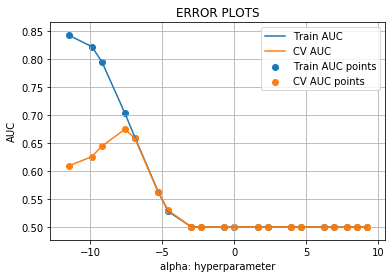

In [143]:
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR1 = SGDClassifier(loss = 'log', penalty = 'l1', alpha = i , max_iter = 1000,class_weight='balanced')
    LR1.fit(Xtrain1, y_train)

    y_train_pred_bow = LR1.predict_proba(Xtrain1)[:,1]    
    y_cv_pred_bow = LR1.predict_proba(Xcv1)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow))

for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.1.2. Finding The Best Hyperparameter "alpha" with penalty = 'l1'

## We are not able to find the best hyperparameter using penalty = 'l1' regularization so we try it with l2 regularization

# 13.1.3. Finding The Best Hyperparameter "alpha" with penalty = 'l2'

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1106.55it/s]


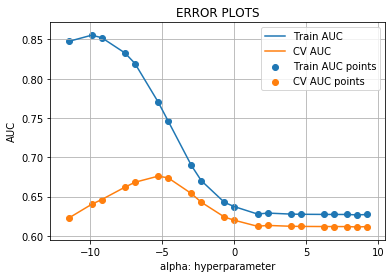

In [144]:
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR1 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i , max_iter = 1000,class_weight='balanced')
    LR1.fit(Xtrain1, y_train)

    y_train_pred_bow = LR1.predict_proba(Xtrain1)[:,1]    
    y_cv_pred_bow = LR1.predict_proba(Xcv1)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow))

for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [145]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_bow = optimal_alpha_cv
print(best_alpha_bow)

Maximum AUC score of cv is: 0.676036075523138
Corresponding alpha value of cv is: 0.005 

0.005


# 13.1.4.  Testing the performance of the model on test data, plotting ROC Curves

In [146]:
# best_alpha_bow = 0.001

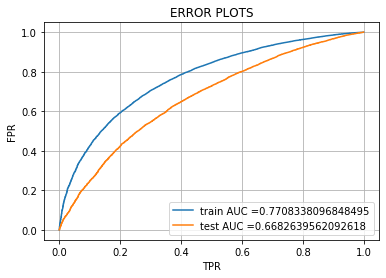

In [147]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR1 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_bow , max_iter = 1000,class_weight='balanced')
LR1.fit(Xtrain1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = LR1.predict_proba(Xtrain1)[:,1]    
y_test_pred_bow =  LR1.predict_proba(Xtest1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.1.5. Building Confusion Matrix

In [148]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [149]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

the maximum value of tpr*(1-fpr) 0.4937716326014255 for threshold 0.496
Train confusion matrix
[[ 5212  2214]
 [12338 29277]]
Test confusion matrix
[[ 3104  2355]
 [ 9930 20663]]


In [150]:
confusion_matrix_train_bow = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
confusion_matrix_test_bow = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

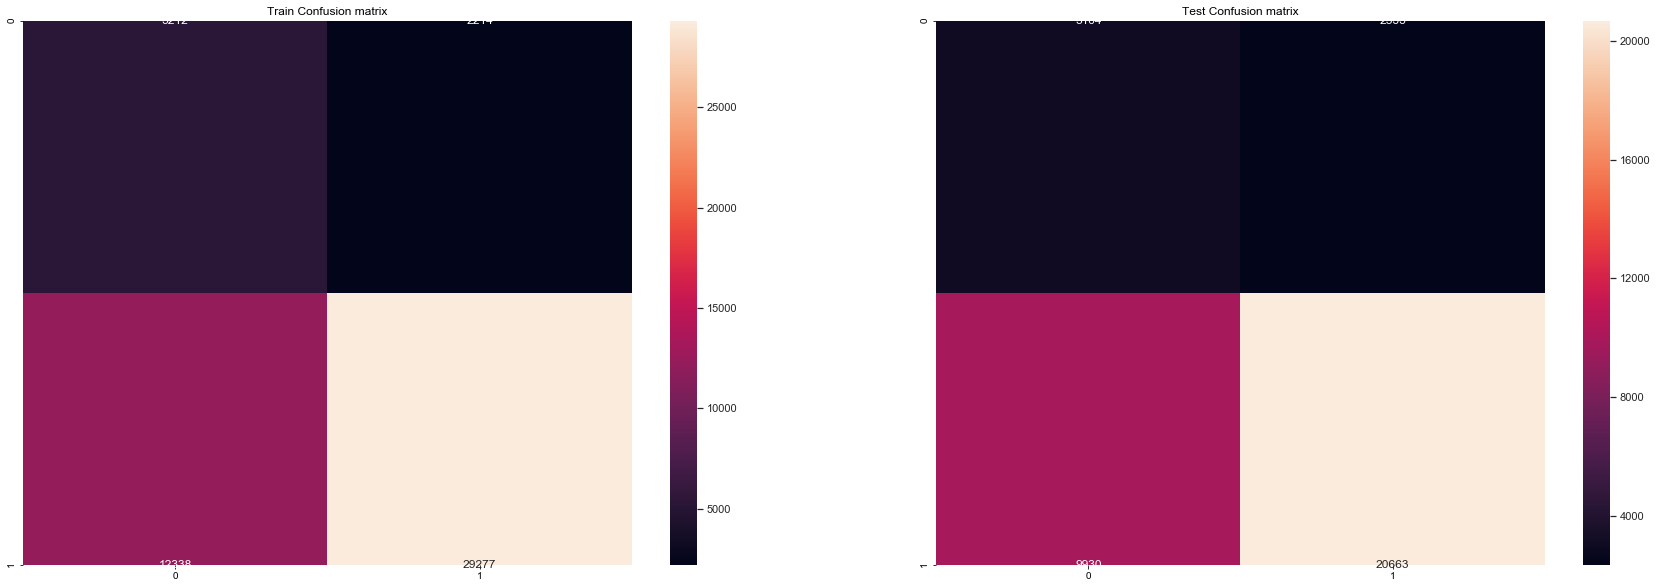

In [151]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
sns.set()
sns.heatmap(confusion_matrix_train_bow,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_bow,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13.2. Appling Logistic Regression on TFIDF, SET 2

# 13.2.1. Finding The Best Hyperparameter "alpha" with penalty = 'l1'

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


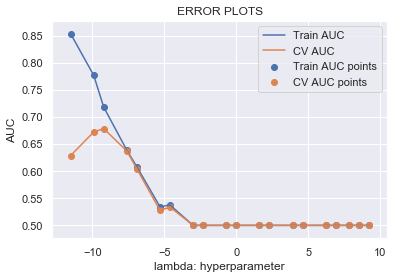

In [152]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR2 = SGDClassifier(loss = 'log', penalty = 'l1', alpha = i , max_iter = 1000,class_weight='balanced')
    LR2.fit(Xtrain2, y_train)

    y_train_pred_tfidf = LR2.predict_proba(Xtrain2)[:,1]    
    y_cv_pred_tfidf = LR2.predict_proba(Xcv2)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_tfidf))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_tfidf))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)


plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.2.1. Finding The Best Hyperparameter "alpha" with penalty = 'l2'

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 869.09it/s]


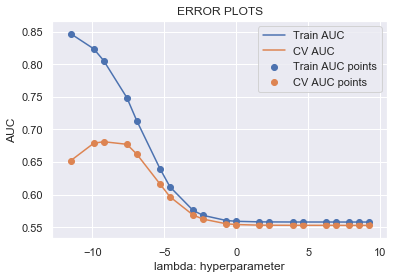

In [153]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR2 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i , max_iter = 1000,class_weight='balanced')
    LR2.fit(Xtrain2, y_train)

    y_train_pred_tfidf = LR2.predict_proba(Xtrain2)[:,1]    
    y_cv_pred_tfidf = LR2.predict_proba(Xcv2)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_tfidf))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_tfidf))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)


plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [154]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_tfidf = optimal_alpha_cv
print(best_alpha_tfidf)

Maximum AUC score of cv is: 0.6810397183417028
Corresponding alpha value of cv is: 0.0001 

0.0001


# 13.2.2. Testing the performance of the model on test data, plotting ROC Curves

In [155]:
# best_alpha_tfidf = 0.05

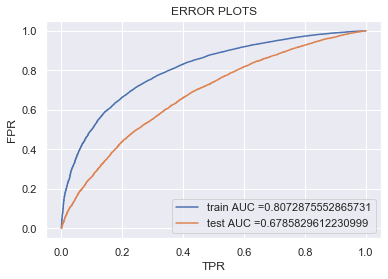

In [156]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR2 =SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_tfidf , max_iter = 1000,class_weight='balanced')
LR2.fit(Xtrain2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = LR2.predict_proba(Xtrain2)[:,1]    
y_test_pred_tfidf = LR2.predict_proba(Xtest2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.2.3. Building Confusion Matrix

In [157]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [158]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

the maximum value of tpr*(1-fpr) 0.5389885105794044 for threshold 0.471
Train confusion matrix
[[ 5587  1839]
 [11802 29813]]
Test confusion matrix
[[ 3145  2314]
 [ 9635 20958]]


In [159]:
confusion_matrix_train_tfidf = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
confusion_matrix_test_tfidf = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

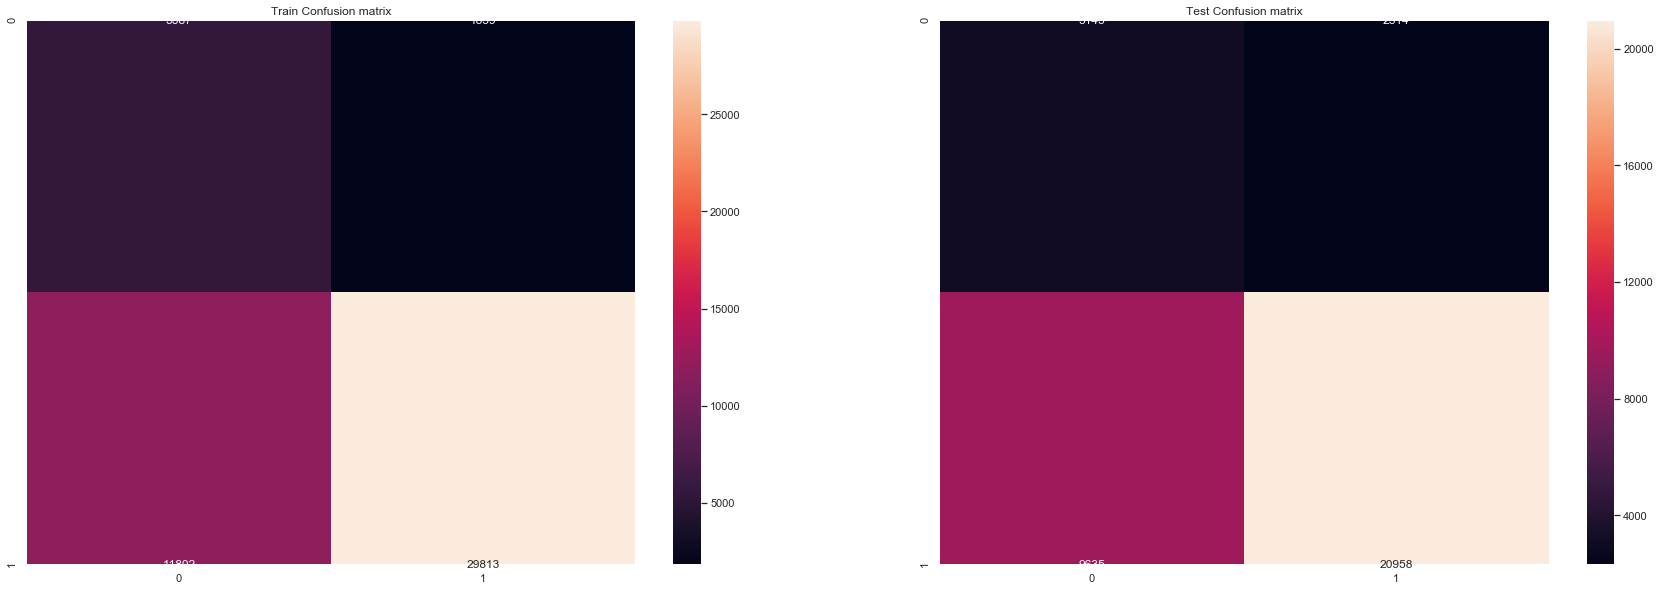

In [160]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidf,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13.3. Appling Logistic Regression on Average Word2Vec, SET3

# 13.3.1. Finding The Best Hyperparameter "alpha" with penalty = 'l1'

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 19953.87it/s]


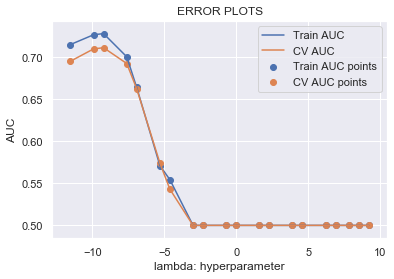

In [161]:
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR3 = SGDClassifier(loss = 'log', penalty = 'l1', alpha = i , max_iter = 1000,class_weight='balanced')
    LR3.fit(Xtrain3, y_train)

    y_train_pred_avgw2v = LR3.predict_proba(Xtrain3)[:,1]    
    y_cv_pred_avgw2v = LR3.predict_proba(Xcv3)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_avgw2v))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_avgw2v))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)
    
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.3.1. Finding The Best Hyperparameter "alpha" with penalty = 'l2'

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


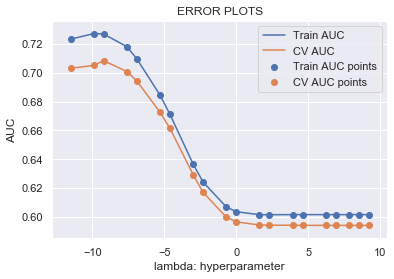

In [162]:
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR3 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i , max_iter = 1000,class_weight='balanced')
    LR3.fit(Xtrain3, y_train)

    y_train_pred_avgw2v = LR3.predict_proba(Xtrain3)[:,1]    
    y_cv_pred_avgw2v = LR3.predict_proba(Xcv3)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_avgw2v))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_avgw2v))
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)
    
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [163]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_avgw2v = optimal_alpha_cv
print(best_alpha_avgw2v)

Maximum AUC score of cv is: 0.708466552276801
Corresponding alpha value of cv is: 0.0001 

0.0001


# 13.3.2. Testing the performance of the model on test data, plotting ROC Curves

In [164]:
# best_alpha_avgw2v = 0.1

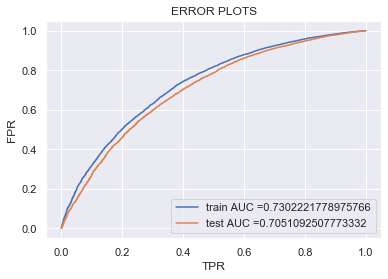

In [165]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR3 =SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_avgw2v , max_iter = 1000,class_weight='balanced')
LR3.fit(Xtrain3, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_avgw2v = LR3.predict_proba(Xtrain3)[:,1]    
y_test_pred_avgw2v = LR3.predict_proba(Xtest3)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avgw2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avgw2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.3.3. Building Confusion Matrix

In [166]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [167]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avgw2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avgw2v, best_t)))

the maximum value of tpr*(1-fpr) 0.45037643068463334 for threshold 0.403
Train confusion matrix
[[ 4651  2775]
 [11690 29925]]
Test confusion matrix
[[ 3210  2249]
 [ 8749 21844]]


In [168]:
confusion_matrix_train_avgw2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avgw2v, best_t)))
confusion_matrix_test_avgw2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avgw2v, best_t)))

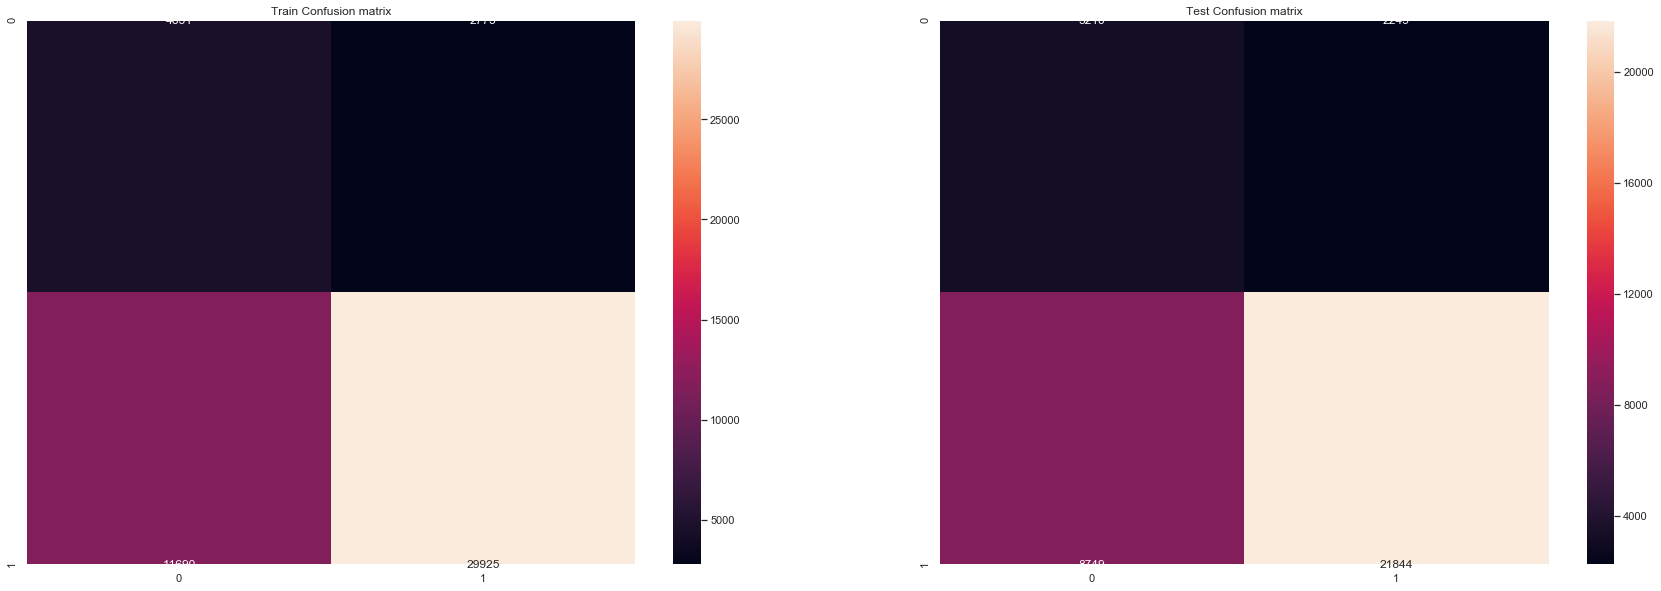

In [169]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_avgw2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_avgw2v,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13.4. Appling Logistic Regression on TFIDF Word2Vec, SET4

# 13.4.1. Finding The Best Hyperparameter "alpha" with penalty = 'l1'

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


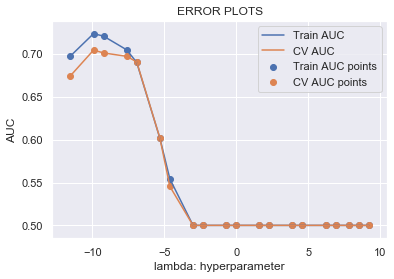

In [170]:
import math 
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR4 = SGDClassifier(loss = 'log', penalty = 'l1', alpha = i , max_iter = 1000,class_weight='balanced')
    LR4.fit(Xtrain4, y_train)

    y_train_pred_tfidfw2v = LR4.predict_proba(Xtrain4)[:,1]    
    y_cv_pred_tfidfw2v = LR4.predict_proba(Xcv4)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_tfidfw2v))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_tfidfw2v))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.4.1. Finding The Best Hyperparameter "alpha" with penalty = 'l2'

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20006.22it/s]


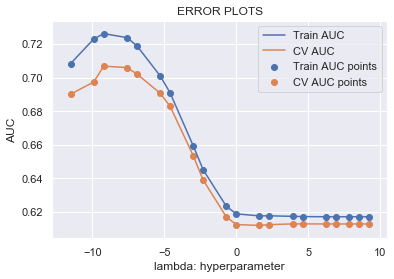

In [171]:
import math 
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR4 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i , max_iter = 1000,class_weight='balanced')
    LR4.fit(Xtrain4, y_train)

    y_train_pred_tfidfw2v = LR4.predict_proba(Xtrain4)[:,1]    
    y_cv_pred_tfidfw2v = LR4.predict_proba(Xcv4)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_tfidfw2v))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_tfidfw2v))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [172]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_tfidfw2v = optimal_alpha_cv
print(best_alpha_tfidfw2v)

Maximum AUC score of cv is: 0.7067997029822874
Corresponding alpha value of cv is: 0.0001 

0.0001


# 13.4.2. Testing the performance of the model on test data, plotting ROC Curves

In [173]:
# best_alpha_tfidfw2v = 0.007

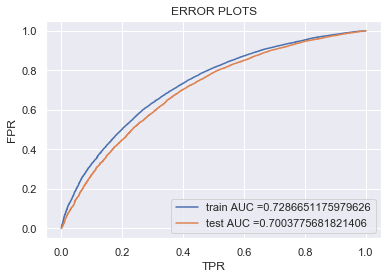

In [174]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR4 =SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_tfidfw2v , max_iter = 1000,class_weight='balanced')
LR4.fit(Xtrain4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidfw2v = LR4.predict_proba(Xtrain4)[:,1]    
y_test_pred_tfidfw2v = LR4.predict_proba(Xtest4)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidfw2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidfw2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.4.3. Building Confusion Matrix

In [175]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [176]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidfw2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidfw2v, best_t)))

the maximum value of tpr*(1-fpr) 0.44817277598744387 for threshold 0.481
Train confusion matrix
[[ 4879  2547]
 [13228 28387]]
Test confusion matrix
[[ 3451  2008]
 [10053 20540]]


In [177]:
confusion_matrix_train_tfidfw2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidfw2v, best_t)))
confusion_matrix_test_tfidfw2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidfw2v, best_t)))

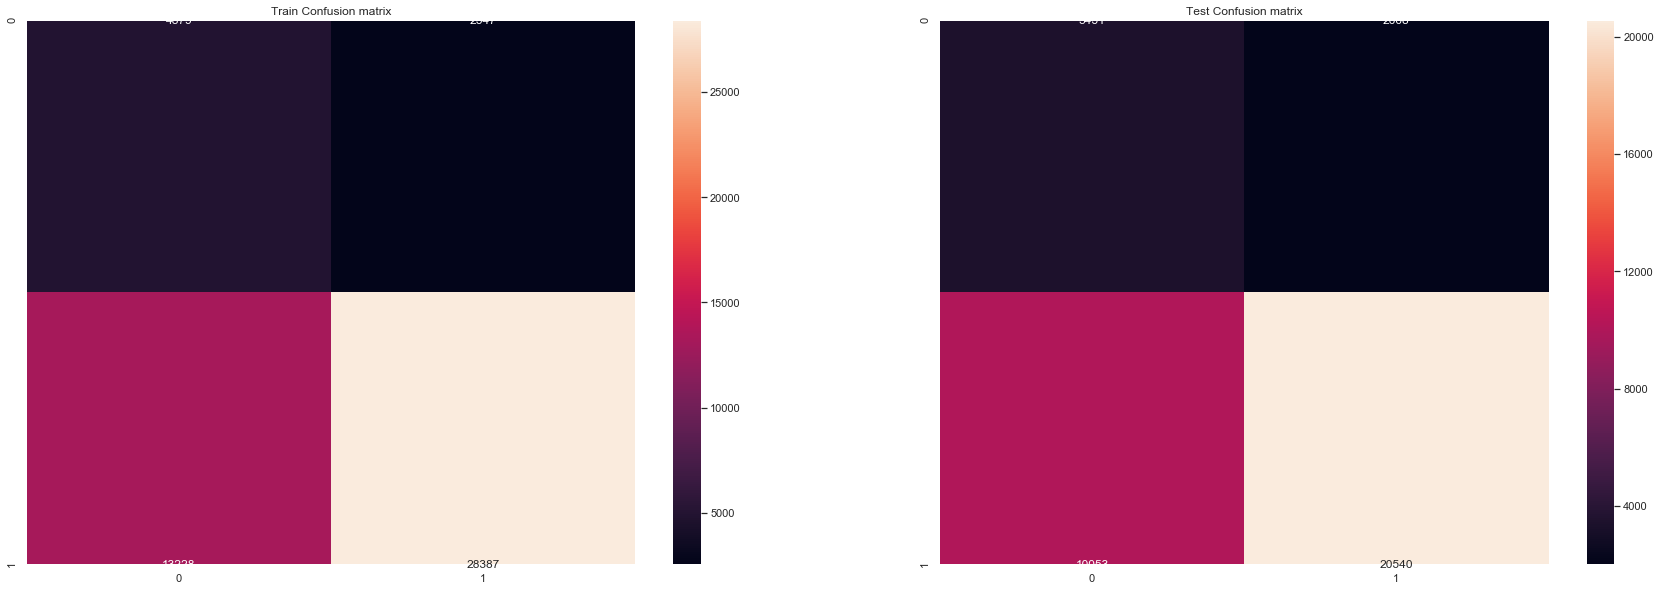

In [178]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidfw2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidfw2v,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13.4.4. Finding The Best Hyperparameter "alpha" with penalty = 'l2' using LogisticRegression classifier

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1243.49it/s]


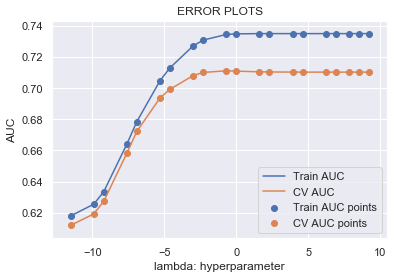

In [179]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_C =[]
for i in tqdm(alpha):
    LR4 = LogisticRegression(penalty = 'l2', C = i,class_weight='balanced')
    LR4.fit(Xtrain4, y_train)

    y_train_pred_tfidfw2v = LR4.predict_proba(Xtrain4)[:,1]    
    y_cv_pred_tfidfw2v = LR4.predict_proba(Xcv4)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_tfidfw2v))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_tfidfw2v))
    
for a in tqdm(alpha):
    b = math.log(a)
    log_C.append(b)


plt.plot(log_C, train_auc, label='Train AUC')
plt.plot(log_C, cv_auc, label='CV AUC')

plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [180]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_C = optimal_alpha_cv
print(best_alpha_C)

Maximum AUC score of cv is: 0.7111344796492414
Corresponding alpha value of cv is: 0.5 

0.5


# 13.4.5. Testing the performance of the model on test data, plotting ROC Curves

In [181]:
# best_alpha_lr_tfidfw2v = 0.01

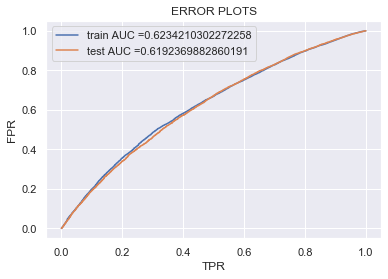

In [182]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR4 =SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_C, max_iter = 1000,class_weight='balanced')
LR4.fit(Xtrain4, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidfw2v = LR4.predict_proba(Xtrain4)[:,1]    
y_test_pred_tfidfw2v = LR4.predict_proba(Xtest4)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidfw2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidfw2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.4.6. Building Confusion Matrix

In [183]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [184]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidfw2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidfw2v, best_t)))

the maximum value of tpr*(1-fpr) 0.35041566274202635 for threshold 0.496
Train confusion matrix
[[ 4550  2876]
 [17815 23800]]
Test confusion matrix
[[ 3321  2138]
 [13291 17302]]


In [185]:
confusion_matrix_train_tfidfw2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidfw2v, best_t)))
confusion_matrix_test_tfidfw2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidfw2v, best_t)))

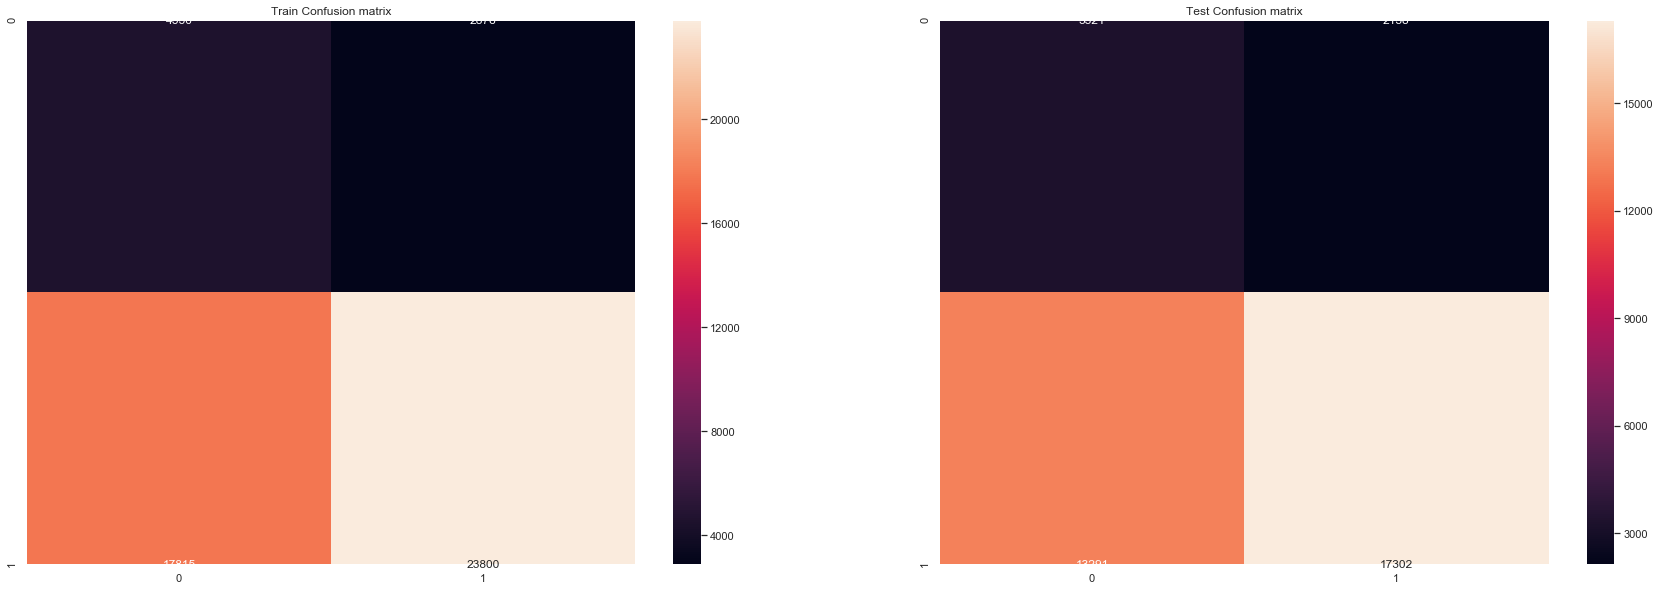

In [186]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_tfidfw2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidfw2v,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13.5. Appling Logistic Regression on SET5

# 13.5.1. Finding The Best Hyperparameter "alpha" with penalty = 'l2'

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


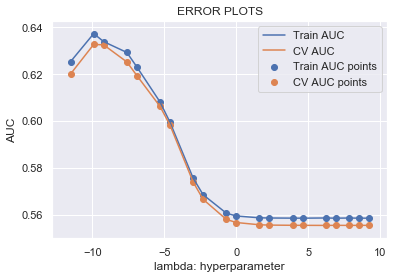

In [187]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
# alpha = [1, 0.7, 0.6,0.5,0.4,0.3,0.2,1]
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
         500, 1000, 2500, 5000, 10000]
log_alpha = []
for i in tqdm(alpha):
    LR5 = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i , max_iter = 1000,class_weight = 'balanced')
    LR5.fit(Xtrain5, y_train)

    y_train_pred_scores = LR5.predict_proba(Xtrain5)[:,1]    
    y_cv_pred_scores = LR5.predict_proba(Xcv5)[:,1]

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred_scores))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_scores))

for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)
    
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("lambda: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

In [188]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_score = optimal_alpha_cv
print(best_alpha_score)

Maximum AUC score of cv is: 0.632679984545602
Corresponding alpha value of cv is: 5e-05 

5e-05


# 13.5.2. Testing the performance of the model on test data, plotting ROC Curves

In [189]:
# best_alpha_score = 0.2

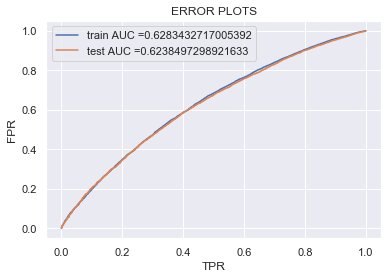

In [190]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


LR5 =SGDClassifier(loss = 'log', penalty = 'l2', alpha = best_alpha_tfidfw2v , max_iter = 1000,class_weight='balanced')
LR5.fit(Xtrain5, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_scores = LR5.predict_proba(Xtrain5)[:,1]    
y_test_pred_scores = LR5.predict_proba(Xtest5)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_scores)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_scores)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# 13.5.3. Building Confusion Matrix

In [191]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [192]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_scores, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_scores, best_t)))

the maximum value of tpr*(1-fpr) 0.35252013061776993 for threshold 0.55
Train confusion matrix
[[ 4162  3264]
 [15440 26175]]
Test confusion matrix
[[ 2986  2473]
 [11218 19375]]


In [193]:
confusion_matrix_train_scores = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_scores, best_t)))
confusion_matrix_test_scores = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_scores, best_t)))

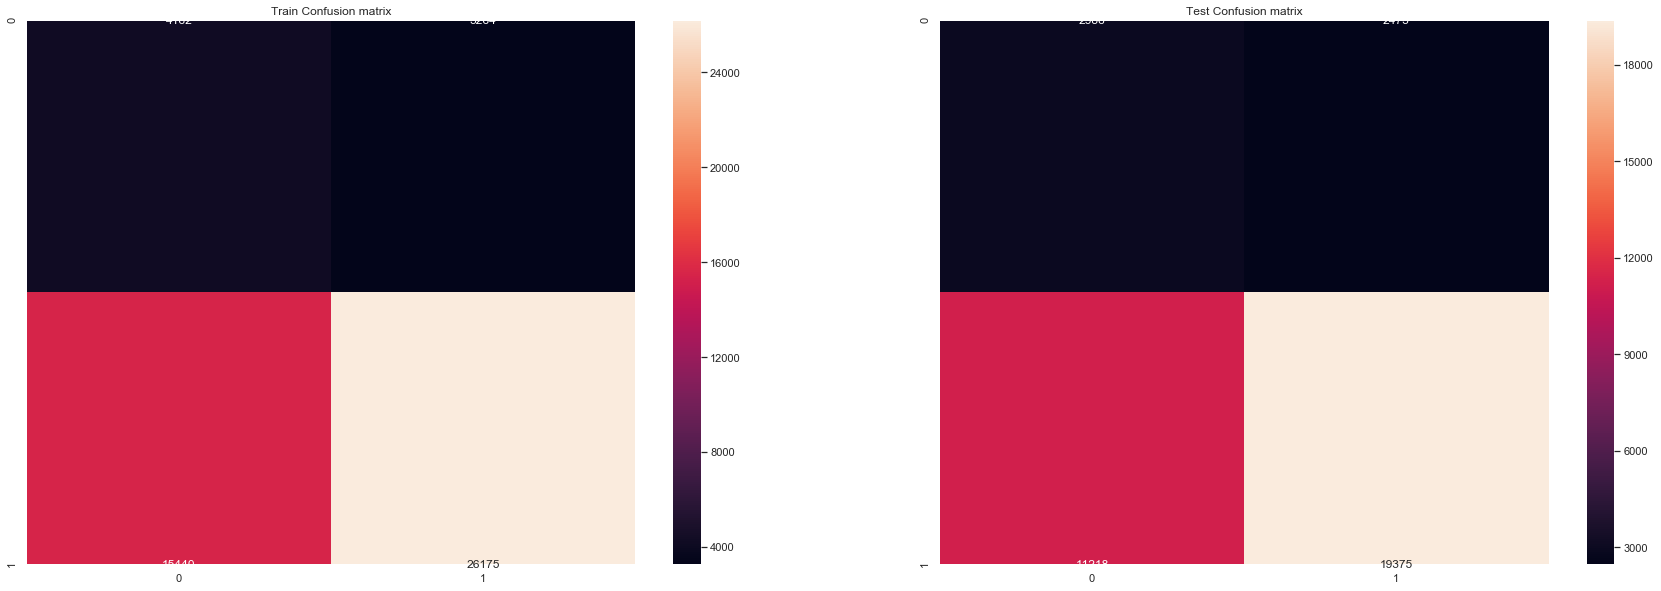

In [194]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 4)
sns.heatmap(confusion_matrix_train_scores,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_scores,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 14. Conclusion

In [195]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "Train AUC","Test AUC"]

x.add_row(["BOW", "SGD Classifier using l2 regularization", 0.005, 0.7708,0.6682])
x.add_row(["TFIDF", "SGD Classifier using l2 regularization", 0.0001, 0.8072,0.6785])
x.add_row(["Average W2V", "SGD Classifier using l2 regularization", 0.0001 , 0.7302,0.7051])
x.add_row(["TFIDF W2V","SGD Classifier using l2 regularization", 0.0001, 0.7286,0.7003])
x.add_row(["TFIDF W2V","Logistic Regression Classifier with l2 regularization", 0.5, 0.6234,0.6192])
x.add_row(["Numerical + Categorical","SGD Classifier using l2 regularization", 5e-05, 0.6283,0.6238])



In [196]:
print(x)

+-------------------------+-------------------------------------------------------+-----------------+-----------+----------+
|        Vectorizer       |                         Model                         | Hyper parameter | Train AUC | Test AUC |
+-------------------------+-------------------------------------------------------+-----------------+-----------+----------+
|           BOW           |         SGD Classifier using l2 regularization        |      0.005      |   0.7708  |  0.6682  |
|          TFIDF          |         SGD Classifier using l2 regularization        |      0.0001     |   0.8072  |  0.6785  |
|       Average W2V       |         SGD Classifier using l2 regularization        |      0.0001     |   0.7302  |  0.7051  |
|        TFIDF W2V        |         SGD Classifier using l2 regularization        |      0.0001     |   0.7286  |  0.7003  |
|        TFIDF W2V        | Logistic Regression Classifier with l2 regularization |       0.5       |   0.6234  |  0.6192  |
